In [2]:
!pip3 install pyLDAvis
import gensim
from gensim import corpora
from gensim import models
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import numpy as np
import random
from glob import glob
from string import punctuation

import random
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
from dateutil import parser
import numpy as np
from tqdm import tqdm

from nltk.tokenize import TreebankWordTokenizer

     |████████████████████████████████| 2.6 MB 7.7 MB/s eta 0:00:01
     |████████████████████████████████| 99 kB 27.7 MB/s eta 0:00:01
     |████████████████████████████████| 11.8 MB 17.9 MB/s eta 0:00:01
     |████████████████████████████████| 341 kB 14.5 MB/s eta 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /Users/anne/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
print(f"Your gensim version is {gensim.__version__}. This notebook assumes that you have version 4.0 or higher. If not, please upgrade.")
assert int(gensim.__version__[0])>=4

print(f"Your pyLDAvis version is {pyLDAvis.__version__}. This notebook assumes that you have version 3.0 or higher. If not, please upgrade.")
assert int(pyLDAvis.__version__[0])>=3

Your gensim version is 4.3.1. This notebook assumes that you have version 4.0 or higher. If not, please upgrade.
Your pyLDAvis version is 3.4.0. This notebook assumes that you have version 3.0 or higher. If not, please upgrade.


LDA is probabilistic method. As a consequence, you may find slight variations in results for different runs of the model. To make sure our findings are reproducable, we have to set a seed. In addition, we have to use `distributed=False` to get reproducable findings. 

In [5]:
random.seed(2022)
np.random.seed(2022)

In [6]:
## load data
PATH = "../../week01/exercises/articles"#use the data that we've also worked with in week 2
#PATH = 'path/to/folder/with/articles' 

In [8]:
RANDOM_N = 2000

## Helper function to read in the data. 
# Don't panic if you do not understand each line of code; try to follow along--but we do not expect you to write such helper functions yourself from scratch

def read_data(listofoutlets, RANDOM_N):
    date = []
    title = []
    outlets = []
    texts = []
    for outlet in listofoutlets:
        
        for file in random.choices(glob(f'{PATH}/*/{outlet}/*'), k=RANDOM_N):
            date.append(file.split('--')[-2])
            title.append(file.split('--')[-1])
            with open(file) as f:
                texts.append(f.read())
                outlets.append(outlet)
    return date, title, texts, outlets

dates, title, texts, outlets = read_data(['Infowars'], RANDOM_N)

In [9]:
len(texts)

2000

In [10]:
texts[0][:500]

'Tucker Carlson told the Heritage Foundation the best way for conservatives to take back America is to have more children and raise them the way that you want, consistent with your beliefs.\n\nI grew up in a world where it was considered embarrassing to have more than two children, Carlson told Daily Signal editor-in-chief Rob Bluey at The Heritage Foundations 41st annual Resource Bank meeting in Fort Lauderdale, Florida last week.\n\nI dont think thats the case now among middle-class, upper middle-c'

In [11]:
texts_clean = [text.lower() for text in texts]
texts_clean=[" ".join(text.split()) for text in texts_clean]  #remove dubble spaces
texts_clean = ["".join([l for l in text if l not in punctuation]) for text in texts_clean] #remove punctuaction
texts_clean[0][:500]

'tucker carlson told the heritage foundation the best way for conservatives to take back america is to have more children and raise them the way that you want consistent with your beliefs i grew up in a world where it was considered embarrassing to have more than two children carlson told daily signal editorinchief rob bluey at the heritage foundations 41st annual resource bank meeting in fort lauderdale florida last week i dont think thats the case now among middleclass upper middleclass people '

## manually removing stopwords

In [12]:
mystopwords = set(stopwords.words('english')) # use default NLTK stopword list; alternatively:
# mystopwords = set(open('mystopwordfile.txt').readlines())  #read stopword list from a textfile with one stopword per line
texts_clean = [" ".join(word for word in text.split() if word not in mystopwords) for text in texts_clean]
texts_clean[0][:500]

'tucker carlson told heritage foundation best way conservatives take back america children raise way want consistent beliefs grew world considered embarrassing two children carlson told daily signal editorinchief rob bluey heritage foundations 41st annual resource bank meeting fort lauderdale florida last week dont think thats case among middleclass upper middleclass people said first rewarding greatest fun thing also profound thing dont like direction country children raise way want consistent b'

## Tokenize texts

In [13]:
tokenized_texts_clean = [TreebankWordTokenizer().tokenize(text) for text in texts_clean ] # tokenize texts; convert all strings to a list of tokens
tokenized_texts_clean[0][:500]

['tucker',
 'carlson',
 'told',
 'heritage',
 'foundation',
 'best',
 'way',
 'conservatives',
 'take',
 'back',
 'america',
 'children',
 'raise',
 'way',
 'want',
 'consistent',
 'beliefs',
 'grew',
 'world',
 'considered',
 'embarrassing',
 'two',
 'children',
 'carlson',
 'told',
 'daily',
 'signal',
 'editorinchief',
 'rob',
 'bluey',
 'heritage',
 'foundations',
 '41st',
 'annual',
 'resource',
 'bank',
 'meeting',
 'fort',
 'lauderdale',
 'florida',
 'last',
 'week',
 'dont',
 'think',
 'thats',
 'case',
 'among',
 'middleclass',
 'upper',
 'middleclass',
 'people',
 'said',
 'first',
 'rewarding',
 'greatest',
 'fun',
 'thing',
 'also',
 'profound',
 'thing',
 'dont',
 'like',
 'direction',
 'country',
 'children',
 'raise',
 'way',
 'want',
 'consistent',
 'beliefs',
 'carlson',
 'said',
 'seems',
 'like',
 'answers',
 'basic',
 'naturebased',
 'answers',
 'opinion',
 'everything',
 'thats',
 'basic',
 'kids',
 'raise',
 'decent',
 'children',
 'carlson',
 'continued',
 'secon

## prepare the corpus for topic modelling

In [14]:
raw_m1 = tokenized_texts_clean
id2word_m1 = corpora.Dictionary(raw_m1)   # assign a token_id to each word
ldacorpus_m1 = [id2word_m1.doc2bow(text) for text in raw_m1] 

lda_m1 = models.LdaModel(ldacorpus_m1, id2word=id2word_m1, num_topics=10)
lda_m1.print_topics()

[(0,
  '0.007*"said" + 0.006*"would" + 0.006*"trump" + 0.005*"one" + 0.005*"us" + 0.004*"fbi" + 0.003*"president" + 0.003*"also" + 0.003*"house" + 0.003*"kavanaugh"'),
 (1,
  '0.008*"said" + 0.008*"trump" + 0.006*"president" + 0.005*"us" + 0.004*"people" + 0.004*"one" + 0.004*"would" + 0.004*"new" + 0.003*"also" + 0.003*"state"'),
 (2,
  '0.010*"trump" + 0.009*"said" + 0.006*"people" + 0.006*"president" + 0.004*"one" + 0.004*"media" + 0.003*"new" + 0.003*"would" + 0.003*"fbi" + 0.003*"also"'),
 (3,
  '0.011*"trump" + 0.009*"said" + 0.006*"president" + 0.004*"us" + 0.004*"one" + 0.003*"house" + 0.003*"people" + 0.003*"also" + 0.003*"would" + 0.003*"white"'),
 (4,
  '0.008*"trump" + 0.005*"said" + 0.004*"fbi" + 0.004*"also" + 0.004*"us" + 0.004*"would" + 0.004*"president" + 0.003*"people" + 0.003*"news" + 0.003*"former"'),
 (5,
  '0.015*"trump" + 0.007*"president" + 0.004*"white" + 0.004*"said" + 0.004*"also" + 0.004*"people" + 0.004*"cnn" + 0.003*"told" + 0.003*"paul" + 0.003*"would"'),

### Use TFidF instead of word counts

In [15]:
ldacorpus_m2 = ldacorpus_m1 # reuse corpus from Model 1 
id2word_m2 = id2word_m1 # and thus, also use id2word-mapping

tfidfcorpus_m2 = models.TfidfModel(ldacorpus_m2)

lda_m2 = models.ldamodel.LdaModel(corpus=tfidfcorpus_m2[ldacorpus_m2],id2word=id2word_m2,num_topics=10)
lda_m2.print_topics(num_words=5)

[(0,
  '0.001*"trump" + 0.001*"fbi" + 0.001*"president" + 0.001*"house" + 0.001*"video"'),
 (1,
  '0.001*"jones" + 0.001*"trump" + 0.001*"said" + 0.001*"president" + 0.001*"alex"'),
 (2,
  '0.001*"trump" + 0.001*"white" + 0.001*"people" + 0.001*"house" + 0.001*"democrats"'),
 (3,
  '0.001*"trump" + 0.001*"news" + 0.001*"border" + 0.001*"fake" + 0.001*"president"'),
 (4,
  '0.001*"trump" + 0.001*"kavanaugh" + 0.001*"president" + 0.001*"infowars" + 0.001*"said"'),
 (5,
  '0.001*"trump" + 0.001*"gun" + 0.001*"shooting" + 0.001*"said" + 0.001*"president"'),
 (6,
  '0.001*"trump" + 0.001*"president" + 0.001*"border" + 0.001*"cnn" + 0.001*"said"'),
 (7,
  '0.001*"trump" + 0.001*"democrats" + 0.001*"fbi" + 0.001*"kavanaugh" + 0.001*"gun"'),
 (8,
  '0.001*"trump" + 0.001*"white" + 0.001*"democrats" + 0.001*"people" + 0.001*"said"'),
 (9,
  '0.001*"trump" + 0.001*"campaign" + 0.001*"president" + 0.001*"fbi" + 0.001*"vote"')]

### Using N-grams as features

In [16]:
documents_bigrams = [["_".join(tup) for tup in nltk.ngrams(text.split(),2)] for text in texts_clean] # creates bigrams
documents_bigrams[0][:500] # inspect the results...

['tucker_carlson',
 'carlson_told',
 'told_heritage',
 'heritage_foundation',
 'foundation_best',
 'best_way',
 'way_conservatives',
 'conservatives_take',
 'take_back',
 'back_america',
 'america_children',
 'children_raise',
 'raise_way',
 'way_want',
 'want_consistent',
 'consistent_beliefs',
 'beliefs_grew',
 'grew_world',
 'world_considered',
 'considered_embarrassing',
 'embarrassing_two',
 'two_children',
 'children_carlson',
 'carlson_told',
 'told_daily',
 'daily_signal',
 'signal_editorinchief',
 'editorinchief_rob',
 'rob_bluey',
 'bluey_heritage',
 'heritage_foundations',
 'foundations_41st',
 '41st_annual',
 'annual_resource',
 'resource_bank',
 'bank_meeting',
 'meeting_fort',
 'fort_lauderdale',
 'lauderdale_florida',
 'florida_last',
 'last_week',
 'week_dont',
 'dont_think',
 'think_thats',
 'thats_case',
 'case_among',
 'among_middleclass',
 'middleclass_upper',
 'upper_middleclass',
 'middleclass_people',
 'people_said',
 'said_first',
 'first_rewarding',
 'rewarding

In [17]:
# maybe we want both unigrams and bigrams in the feature set?
documents_uniandbigrams = []
for a,b in zip([text.split() for text in texts_clean],documents_bigrams):
    documents_uniandbigrams.append(a + b)

#and let's inspect the outcomes again.
documents_uniandbigrams[0]

len(documents_uniandbigrams[0]),len(documents_bigrams[0]),len(texts_clean[0].split())

(325, 162, 163)

In [18]:
id2word_m3 = corpora.Dictionary(documents_uniandbigrams)
id2word_m3.filter_extremes(no_below=5, no_above=0.5)

ldacorpus_m3 = [id2word_m3.doc2bow(text) for text in documents_uniandbigrams]
tfidfcorpus_m3 = models.TfidfModel(ldacorpus_m3)

lda_m3 = models.ldamodel.LdaModel(corpus=tfidfcorpus_m3[ldacorpus_m3],id2word=id2word_m3,num_topics=10)
lda_m3.print_topics(num_words=5)

[(0,
  '0.002*"trump" + 0.001*"gun" + 0.001*"fbi" + 0.001*"president" + 0.001*"would"'),
 (1,
  '0.001*"trump" + 0.001*"white" + 0.001*"president" + 0.001*"house" + 0.001*"cnn"'),
 (2,
  '0.002*"trump" + 0.001*"border" + 0.001*"people" + 0.001*"state" + 0.001*"president"'),
 (3,
  '0.001*"trump" + 0.001*"president" + 0.001*"media" + 0.001*"white" + 0.001*"cnn"'),
 (4,
  '0.001*"trump" + 0.001*"democrats" + 0.001*"white" + 0.001*"people" + 0.001*"news"'),
 (5,
  '0.001*"trump" + 0.001*"percent" + 0.001*"president" + 0.001*"cnn" + 0.001*"state"'),
 (6,
  '0.001*"trump" + 0.001*"school" + 0.001*"twitter" + 0.001*"gun" + 0.001*"people"'),
 (7,
  '0.001*"trump" + 0.001*"kavanaugh" + 0.001*"president" + 0.001*"fbi" + 0.001*"clinton"'),
 (8,
  '0.001*"trump" + 0.001*"vote" + 0.001*"kavanaugh" + 0.001*"cnn" + 0.001*"jones"'),
 (9,
  '0.001*"jones" + 0.001*"trump" + 0.001*"infowars" + 0.001*"border" + 0.001*"president"')]

# 2. Model evaluation

In [19]:
# NB: CoherenceModel is only available in newer versions of gensim.
# if it's not available, consider upgrading with `pip3 install gensim -upgrade`

#The greater the number, the better is coherence score

cm1 = models.CoherenceModel(model=lda_m1, corpus=ldacorpus_m1 , dictionary=id2word_m1, coherence='u_mass')  
ch1 = cm1.get_coherence()
cm2 = models.CoherenceModel(model=lda_m2, corpus=ldacorpus_m2, dictionary= id2word_m2, coherence='u_mass')  
ch2 = cm2.get_coherence()
#cm3 = models.CoherenceModel(model=lda_m3, corpus=ldacorpus_m3, coherence='u_mass')
cm3 = models.CoherenceModel(model=lda_m3, corpus=tfidfcorpus_m3[ldacorpus_m3], dictionary= id2word_m3, coherence='u_mass')
ch3 = cm3.get_coherence()

print(f"Coherence of naive model = {ch1}\nCoherence of tfidf model = {ch2}\nCoherence of bigram and unigram model = {ch3}")

Coherence of naive model = -1.418156894354132
Coherence of tfidf model = -2.352990332076792
Coherence of bigram and unigram model = -2.1790985071751754


In [20]:
lda_m2_bad = models.LdaModel(tfidfcorpus_m2[ldacorpus_m2],id2word=id2word_m2, num_topics=10,iterations=1)
print(models.CoherenceModel(model=lda_m2_bad, corpus=tfidfcorpus_m2[ldacorpus_m2], coherence='u_mass').get_coherence())

#lda_m2_good = models.LdaModel(tfidfcorpus_m4[ldacorpus_m4], id2word=id2word_m4, num_topics=10,iterations=50, passes=5)
#print(models.CoherenceModel(model=lda_m4_good, corpus=tfidfcorpus_m4[ldacorpus_m4], coherence='u_mass').get_coherence())

-1.899273623026253


In [21]:
lda_m2_good = models.LdaModel(tfidfcorpus_m2[ldacorpus_m2],id2word=id2word_m2, num_topics=10,iterations=50, passes=5)
print(models.CoherenceModel(model=lda_m2_good, corpus=tfidfcorpus_m2[ldacorpus_m2], coherence='u_mass').get_coherence())

-4.231836147135121


In [27]:
lda_m2_good.top_topics(tfidfcorpus_m2[ldacorpus_m2])

[([(0.0016557233, 'trump'),
   (0.0012779862, 'news'),
   (0.0012422762, 'said'),
   (0.0011585992, 'one'),
   (0.0011175253, 'fbi'),
   (0.0010777843, 'people'),
   (0.0010737053, 'president'),
   (0.0010696563, 'would'),
   (0.0009782744, 'us'),
   (0.0009099573, 'media'),
   (0.0009099417, 'kavanaugh'),
   (0.0009009329, 'democrats'),
   (0.0008998004, 'get'),
   (0.0008968189, 'know'),
   (0.0008861831, 'go'),
   (0.0008832621, 'going'),
   (0.00087184337, 'times'),
   (0.0008709521, 'time'),
   (0.00086184905, 'investigation'),
   (0.0008590011, 'new')],
  -1.4736724066190086),
 ([(0.0014818477, 'kavanaugh'),
   (0.0013616411, 'trump'),
   (0.0011583301, 'fbi'),
   (0.0010352664, 'jones'),
   (0.0010220333, 'police'),
   (0.000997585, 'infowars'),
   (0.000965452, 'school'),
   (0.0009511288, 'president'),
   (0.0009162395, 'alex'),
   (0.00091526634, 'senator'),
   (0.0009088744, 'said'),
   (0.00087584526, 'people'),
   (0.00087128446, 'white'),
   (0.00086939853, 'man'),
   (0.

## Visualize

In [22]:
vis_data = gensimvis.prepare(lda_m2,ldacorpus_m2,id2word_m2)
pyLDAvis.display(vis_data)

## plot over time

In [22]:
## convert back to df

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
all_topics = lda_m2.get_document_topics(ldacorpus_m2, minimum_probability=0.0)
all_topics_csr = gensim.matutils.corpus2csc(all_topics)
all_topics_numpy = all_topics_csr.T.toarray()
all_topics_df = pd.DataFrame(all_topics_numpy)
all_topics_df.head()

,0,1,2,3,4,5,6,7,8,9
0,0.033665,0.345777,0.000255,0.240517,0.000255,0.000255,0.000255,0.301311,0.077453,0.000255
1,0.000613,0.000613,0.000613,0.000613,0.000613,0.000613,0.088463,0.906631,0.000613,0.000613
2,0.000755,0.000755,0.000755,0.942996,0.000755,0.000755,0.000755,0.050964,0.000755,0.000755
3,0.000854,0.000854,0.535159,0.000854,0.381117,0.000854,0.000854,0.061629,0.016970,0.000854
4,0.000326,0.000326,0.000326,0.000326,0.000326,0.054713,0.000326,0.942682,0.000326,0.000326


In [30]:
all_topics_df.rename(columns= { 0 : "topic_0", 1 : "topic_1", 2 : "topic_2", 3 : "topic_3",
4 : "topic_4", 5 : "topic_5", 6 : "topic_6", 7 : "topic_7", 8 : "topic_8", 9 : "topic_9" },inplace=True)
all_topics_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.033665,0.345777,0.000255,0.240517,0.000255,0.000255,0.000255,0.301311,0.077453,0.000255
1,0.000613,0.000613,0.000613,0.000613,0.000613,0.000613,0.088463,0.906631,0.000613,0.000613
2,0.000755,0.000755,0.000755,0.942996,0.000755,0.000755,0.000755,0.050964,0.000755,0.000755
3,0.000854,0.000854,0.535159,0.000854,0.381117,0.000854,0.000854,0.061629,0.016970,0.000854
4,0.000326,0.000326,0.000326,0.000326,0.000326,0.054713,0.000326,0.942682,0.000326,0.000326


In [31]:
### create a df with the dates and orginal texts

meta = pd.DataFrame(zip(dates, texts))
meta.rename(columns = {0: "date", 1 : "texts"}, inplace=True)

meta.head()

,date,texts
0,2018-02-09,"Former White House aide Rob Porter, who recent..."
1,2018-07-23,Sen. Rand Paul stated Monday that he intends t...
2,2018-02-05,California Rep. Adam Schiff suggested that an ...
3,2018-10-22,With midterm elections right around the corner...
4,2018-10-19,Self-proclaimed future House Speaker Nancy Pel...


In [32]:
### merge with the topic scores per document

final = pd.concat([meta, all_topics_df], axis=1)
final['id'] = final.index
final.head(3)

,date,texts,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,id
0,2018-02-09,"Former White House aide Rob Porter, who recent...",0.033665,0.345777,0.000255,0.240517,0.000255,0.000255,0.000255,0.301311,0.077453,0.000255,0
1,2018-07-23,Sen. Rand Paul stated Monday that he intends t...,0.000613,0.000613,0.000613,0.000613,0.000613,0.000613,0.088463,0.906631,0.000613,0.000613,1
2,2018-02-05,California Rep. Adam Schiff suggested that an ...,0.000755,0.000755,0.000755,0.942996,0.000755,0.000755,0.000755,0.050964,0.000755,0.000755,2


In [33]:
### reshape to long format

long = pd.melt(final, id_vars=['id', 'date', 'texts'], value_vars=[f"topic_{i}" for i in range(0,10)])
long.rename(columns={"variable" : "topic_nr", "value" : "topic_score"}, inplace=True)
long.head(3)

,id,date,texts,topic_nr,topic_score
0,0,2018-02-09,"Former White House aide Rob Porter, who recent...",topic_0,0.033665
1,1,2018-07-23,Sen. Rand Paul stated Monday that he intends t...,topic_0,0.000613
2,2,2018-02-05,California Rep. Adam Schiff suggested that an ...,topic_0,0.000755


In [34]:
# get data in right shape for plotting
import seaborn as sns

long['date'] = long['date'].map(pd.to_datetime)
#plotdf = long.groupby(['topic_nr',pd.Grouper(key='date', freq='M')]).sum().reset_index() 
#plotdf = long.groupby(['topic_nr',pd.Grouper(key='date', freq='M')]).mean().reset_index() #you may also opt for 'mean'

long['month'] = pd.DatetimeIndex(long['date']).month

<AxesSubplot:xlabel='month', ylabel='topic_score'>

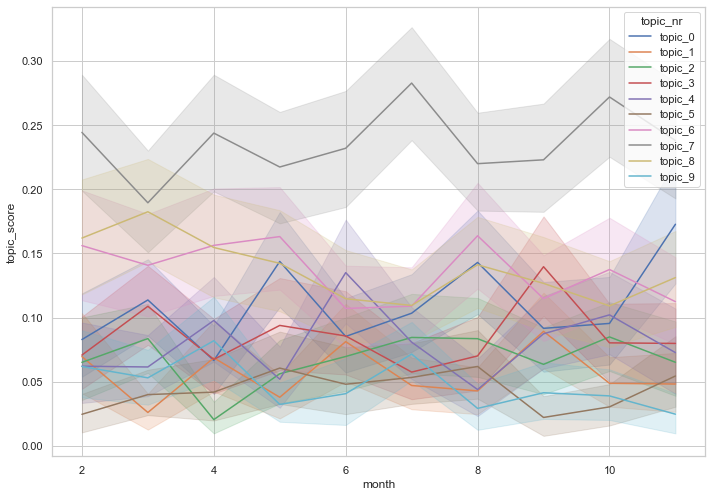

In [35]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("whitegrid")

sns.lineplot(x="month", y="topic_score", hue="topic_nr", data=long)